# EDA

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wordcloud
import emoji
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

all_sw = stopwords.words('spanish')

In [49]:
df = pd.read_csv("Datathon 2024 - Reto Hey - Dataset Público - Sheet1.csv")
df.head()

,date,time,tweet
0,2023-01-01,NaN,"Resuelto, muchísimas gracias , excelente servi..."
1,2023-01-02,NaN,"Muchas gracias, espero su dm"
2,2023-01-02,NaN,Muchas gracias!
3,2023-01-02,NaN,Algo similar me paso. Quería renovar mi token ...
4,2023-01-02,NaN,Yeeeei! a través de mi cuenta en acabo de cont...


## Wordcloud

### Removing Emojis

In [14]:
# Removing emojis as first attempt to create wordloud

def remove_emojis(text):
    return emoji.replace_emoji(text, '')

def emoji_to_text(text):
    return emoji.demojize(text)

def remove_stopwords(text):
    words = word_tokenize(text, language='spanish')
    return ' '.join([word.lower() for word in words if word.lower() not in all_sw])

def clean_text(df, emoji='remove', strip=True, sw=True):
    df1 = df.copy()
    if emoji == 'remove':
        df1['clean_tweet'] = df1['tweet'].apply(remove_emojis)
    elif emoji == 'text':
        df1['clean_tweet'] = df1['tweet'].apply(emoji_to_text)
    
    if strip:
        df1['clean_tweet'] = df1['clean_tweet'].str.rstrip()
        df1['clean_tweet'] = df1['clean_tweet'].str.replace(r'\s+', ' ', regex=True).str.strip()

    if sw:
        df1['clean_tweet'] = df1['clean_tweet'].apply(remove_stopwords)
    return df1

In [50]:
df1 = clean_text(df)
df1['clean_tweet'].iloc[7]

'muchas gracias'

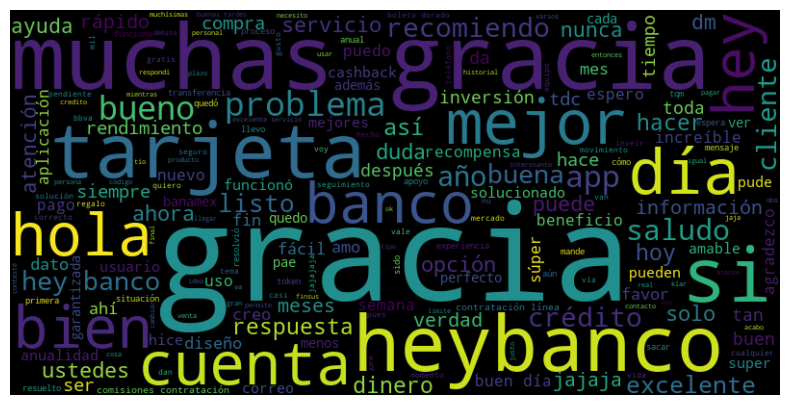

In [51]:
# Join all text in one string
text = ' '.join(df1['clean_tweet'].tolist())

# Wordcloud
wc = wordcloud.WordCloud(width=800, height=400).generate(text)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### New stopwords

In [52]:
new_sw = ['heybanco', 'muchas', 'mucha', 'gracia', 'gracias', 'hola', 'día', 'si', 'tarjeta', 'listo', 'hey',
          'banco', 'tan', 'hace', 'solo', 'favor', 'ahora', 'así', 'días', 'hola', 'queremos', 've']
all_sw = list(all_sw) + new_sw

df2 = clean_text(df1, emoji='remove', strip=False)

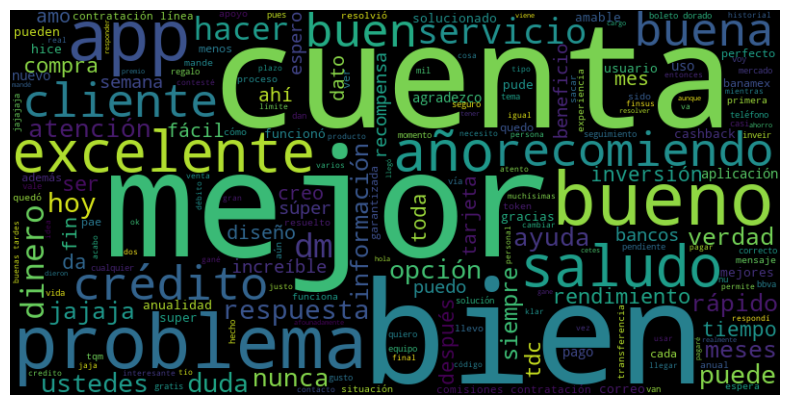

In [53]:
# Join all text in one string
text = ' '.join(df2['clean_tweet'].tolist())

# Wordcloud
wc = wordcloud.WordCloud(width=800, height=400).generate(text)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## Clustering

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [54]:
# TFIDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=all_sw, ngram_range=(1,2))
X = tfidf_vectorizer.fit_transform(df2['clean_tweet'])

# Clustering
number_of_clusters = 4
kmeans = KMeans(n_clusters=number_of_clusters, init='k-means++', max_iter=100, n_init=1, random_state=0)
kmeans.fit(X)

order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names_out()

for i in range(number_of_clusters):
    print('Cluster %d: ' %i),
for ind in order_centroids[i, :10]:
    print(' %s' % terms[ind])

Cluster 0: 
Cluster 1: 
Cluster 2: 
Cluster 3: 
 mejor
 bien
 saludos
 quedó
 jajaja
 recomiendo
 bueno
 buen
 solucionado
 ayuda


WordCloud for cluster 1


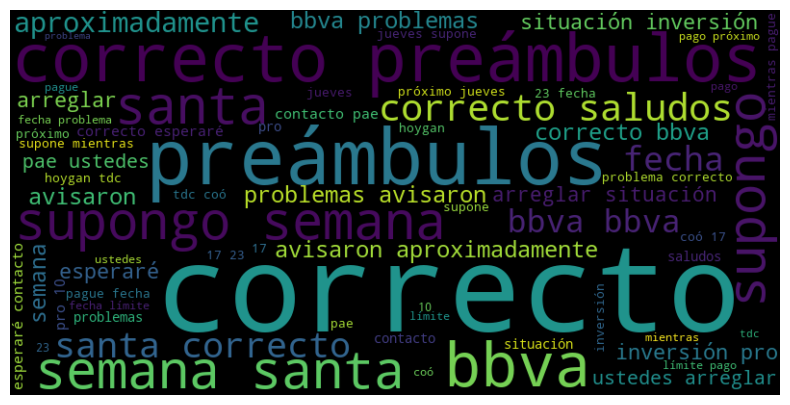

WordCloud for cluster 2


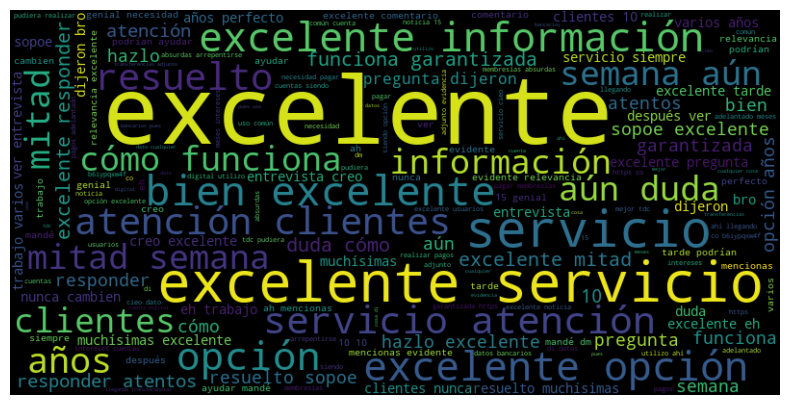

WordCloud for cluster 3


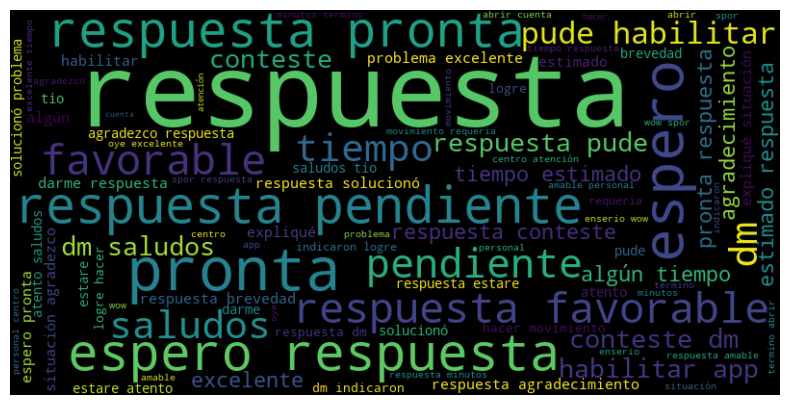

WordCloud for cluster 4


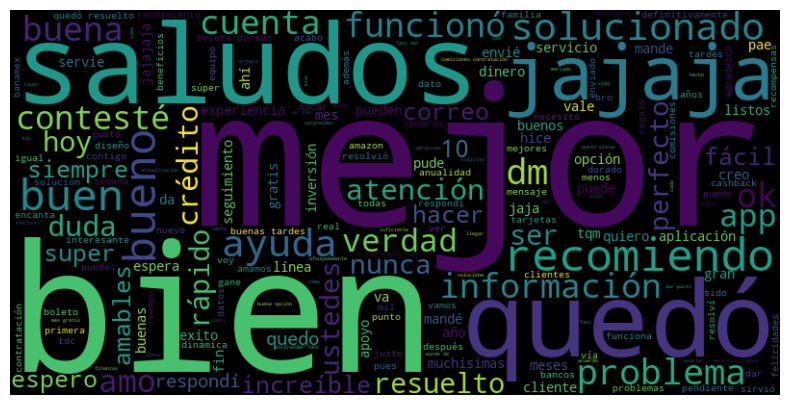

In [55]:
# Crear una función para generar WordClouds para cada cluster
def generate_wordclouds(cluster_model, terms):
    # Número de clusters
    n_clusters = cluster_model.n_clusters
    order_centroids = cluster_model.cluster_centers_.argsort()[:, ::-1]
    
    for i in range(n_clusters):
        print(f"WordCloud for cluster {i+1}")
        terms_freq = {}
        for ind in order_centroids[i, :]:  # Tomamos los top 10 términos de cada cluster
            terms_freq[terms[ind]] = cluster_model.cluster_centers_[i, ind]
        
        # Crear el WordCloud
        wc = wordcloud.WordCloud(width=800, height=400).generate_from_frequencies(terms_freq)
        
        # Visualización
        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.show()

generate_wordclouds(kmeans, terms)

## Topic Modeling

In [60]:
from gensim import corpora, models
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer

# Preprocessing the data
tokenizer = RegexpTokenizer(r'\w+')
stemmer = SnowballStemmer('spanish')

def preprocess(text):
    df1 = df.copy()
    tokens = tokenizer.tokenize(text.lower())
    #stemmed_tokens = [stemmer.stem(i) for i in tokens]
    return tokens

df3 = df2.copy()
df3['processed'] = df3['clean_tweet'].apply(preprocess)

# Creating a dictionary from the data
dictionary = corpora.Dictionary(df3['processed'])

# Creating a document-term matrix
corpus = [dictionary.doc2bow(text) for text in df3['processed']]

In [61]:
# Building the LDA model
lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15, random_state=0)

# Printing the topics
topics = lda_model.print_topics()
for topic in topics:
    print(topic)

(0, '0.012*"dm" + 0.009*"cuenta" + 0.009*"quedó" + 0.008*"excelente" + 0.006*"gracias" + 0.006*"buen" + 0.006*"jajaja" + 0.006*"información" + 0.006*"dinero" + 0.005*"sacar"')
(1, '0.011*"saludos" + 0.011*"mejor" + 0.010*"respuesta" + 0.008*"recomiendo" + 0.007*"opción" + 0.007*"app" + 0.005*"solucionado" + 0.005*"problema" + 0.005*"crédito" + 0.005*"años"')
(2, '0.015*"bien" + 0.012*"app" + 0.007*"servicio" + 0.007*"hoy" + 0.007*"correo" + 0.006*"amo" + 0.006*"excelente" + 0.005*"duda" + 0.005*"funciona" + 0.005*"cliente"')
(3, '0.008*"línea" + 0.007*"comisiones" + 0.006*"contratación" + 0.005*"experiencia" + 0.005*"crédito" + 0.005*"te" + 0.005*"1" + 0.004*"dinero" + 0.004*"2" + 0.004*"alternativas"')
(4, '0.008*"10" + 0.007*"buena" + 0.007*"atención" + 0.007*"mejor" + 0.007*"problema" + 0.007*"cuenta" + 0.006*"meses" + 0.006*"ustedes" + 0.006*"ser" + 0.005*"buen"')


**Topics**
- 0: Comentario Psoitivo
- 1: Recomendaciones
- 2: App
- 3: Crédito
- 4: Servicio

In [58]:
lda_model.show_topic(1)

[('saludos', 0.011166594),
 ('mejor', 0.011130586),
 ('respuesta', 0.010491417),
 ('recomiendo', 0.007918391),
 ('opción', 0.007163712),
 ('app', 0.006655869),
 ('solucionado', 0.0053214096),
 ('problema', 0.0046827346),
 ('crédito', 0.004680596),
 ('años', 0.0046757082)]

## Dataset con Topico

In [65]:
# Palabras por tópico
topics_words = {}

for i in range(5):
    topics = lda_model.show_topic(i)
    words = []
    for topic, score in topics:
        words.append(topic)
    topics_words[i] = words

# Crear columnas para cada palabra clave
for topic, words in topics_words.items():
    for word in words:
        df3[word] = df3['processed'].apply(lambda x: x.count(word))

# Ahora, añadir una columna para el tópico predominante de cada texto
def determine_topic(text):
    scores = {topic: sum(text.count(word) for word in words) for topic, words in topics_words.items()}
    return max(scores, key=scores.get)

df4 = df3.copy()
df4['main_topic'] = df4['processed'].apply(determine_topic)
df4.head()

,date,time,tweet,clean_tweet,processed,dm,cuenta,quedó,excelente,gracias,...,1,2,alternativas,10,buena,atención,meses,ustedes,ser,main_topic
0,2023-01-01,NaN,"Resuelto, muchísimas gracias , excelente servi...","resuelto , muchísimas , excelente servicio sie...","[resuelto, muchísimas, excelente, servicio, si...",0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,2
1,2023-01-02,NaN,"Muchas gracias, espero su dm",", espero dm","[espero, dm]",1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2023-01-02,NaN,Muchas gracias!,!,[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2023-01-02,NaN,Algo similar me paso. Quería renovar mi token ...,similar paso . quería renovar token poder hace...,"[similar, paso, quería, renovar, token, poder,...",0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2023-01-02,NaN,Yeeeei! a través de mi cuenta en acabo de cont...,yeeeei ! través cuenta acabo contratar cuenta ...,"[yeeeei, través, cuenta, acabo, contratar, cue...",0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Clasificación de textos en base a features

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

df5 = df4.copy()

X = df5.iloc[:,5:-1]
y = df5.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [67]:
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       107
           1       0.89      0.62      0.73        26
           2       1.00      0.80      0.89        15
           3       1.00      0.40      0.57         5
           4       0.60      0.30      0.40        10

    accuracy                           0.86       163
   macro avg       0.87      0.62      0.70       163
weighted avg       0.86      0.86      0.84       163



In [68]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       107
           1       0.86      0.92      0.89        26
           2       1.00      0.80      0.89        15
           3       1.00      0.40      0.57         5
           4       0.71      0.50      0.59        10

    accuracy                           0.91       163
   macro avg       0.90      0.72      0.78       163
weighted avg       0.91      0.91      0.91       163



In [69]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       107
           1       0.74      0.96      0.83        26
           2       0.88      0.93      0.90        15
           3       0.50      0.20      0.29         5
           4       0.62      0.50      0.56        10

    accuracy                           0.90       163
   macro avg       0.74      0.71      0.71       163
weighted avg       0.90      0.90      0.89       163



In [70]:
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       107
           1       0.86      0.92      0.89        26
           2       1.00      0.93      0.97        15
           3       1.00      0.60      0.75         5
           4       0.73      0.80      0.76        10

    accuracy                           0.94       163
   macro avg       0.91      0.85      0.87       163
weighted avg       0.95      0.94      0.94       163



In [71]:
# Store model
import pickle

with open('topic_model.pkl', 'wb') as f:
    pickle.dump(model, f)